In [1]:
# !gdown 1dQC6v3Z3FgNVO__HL8mQVjTvmNdvobe5

In [1]:
import torch
from torch import nn
from torchsummary import summary
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import csv

from models.convae import ConvAE
from utils.functions import *
from utils.datasets import 
warnings.filterwarnings('ignore')
%matplotlib inline

# To do:  
1. Preproccess data from edf to csv +
2. First approach based on spectrograms.
3. Second approach http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2018/paper/ABCs2018_paper_216.pdf create rgb image.
4. Third approach: https://sci-hub.hkvisa.net/10.1109/ACCESS.2018.2833746
5. Compare different classifiers.

# Comments  
1. There are 89 recordings with 21 channels and 9 recordings with 22 channels, so for the former I will take only 21 which are presented in the latter. Look at common_electrodes.
2. For the first approch it is strictly necessary for all recordings to be the same length (I will take windows 4096 as in the paper).

In [5]:
PATH = 'eeg_data/'
PATH_TO_SAVE = 'eeg_data_csv/'
PATH_TO_SAVE_TENSORS = 'eeg_data_tensors/'

# parameters are acquired during EDA
common_electrodes = ['EEG FP1-R', 'EEG FP2-R', 'EEG F3-R', 'EEG F4-R', 'EEG C3-R', 'EEG C4-R', 
                     'EEG P3-R', 'EEG P4-R', 'EEG O1-R', 'EEG O2-R', 'EEG F7-R', 'EEG F8-R', 
                     'EEG T3-R', 'EEG T4-R', 'EEG T5-R', 'EEG T6-R', 'EEG FPZ-R', 'EEG FZ-R', 
                     'EEG CZ-R', 'EEG PZ-R', 'EEG OZ-R']


min_length = 21500
filter_params = {'l_freq': 1, 'h_freq': 50, 'method': 'iir', 'n_jobs': -1, 'verbose': False}
Fs = 500
device = get_device()

In [8]:
# get_np_from_edf(PATH, filter_params, PATH_TO_SAVE)
# generate_tensors_from_csv(PATH_TO_SAVE, PATH_TO_SAVE_TENSORS, Fs)

# Model for approach 1

## Dataset

In [3]:
class EegSpec(Dataset):
    def __init__(self,
                 phase: str,
                 data_path: str = 'data'):
        files = os.listdir(f'{data_path}/{phase}')
        self.images = []
        for f in files:
            self.images.append(torch.load(f'{data_path}/' + f'{phase}/' + f))
                         
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

In [4]:
BATCH = 8
epoches = 150
train_data = EegSpec(phase = 'train')
validate_data = EegSpec(phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 4) 
validation_dataloader = DataLoader(validate_data, batch_size = 10, 
                                   shuffle = False, num_workers = 4)
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

## Training

In [14]:
def train(model, epoches, train_dataloader, validation_dataloader, device, criterion, model_name):
    model = model.to(device)
    writer = SummaryWriter(f'runs/{model_name}')
    min_val_loss = np.inf
    for epoch in range(epoches):
        model.train()
        train_loss = 0
        for data in train_dataloader:
            img = data.to(device, dtype = torch.float)
            output = model(img)[0]
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader)

        model.eval() 
        val_loss = 0
        with torch.no_grad():
            for img in validation_dataloader:
                img = data.to(device, dtype = torch.float)
                output = model(img)[0]
                val_loss = criterion(output, img)
                val_loss += val_loss.item()
            val_loss = val_loss / len(validation_dataloader)
            
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(),'best_val_loss_weights.pth')
        print(f'epoch {epoch}/{epoches}\n train loss: {train_loss}\n validation_loss {val_loss}')

In [15]:
# train(model, epoches, train_dataloader, validation_dataloader, device, criterion, 'ConvAE')

In [16]:
model.load_state_dict(torch.load('best_val_loss_weights.pth'))
model.eval();

In [91]:
test_batch = next(iter(train_dataloader)).to(device)

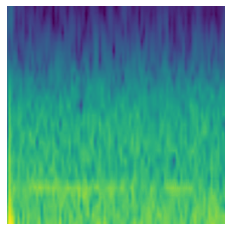

In [92]:
plt.imshow(test_batch[0][0].detach().cpu().numpy());
plt.axis('off');

In [93]:
out = model(test_batch)

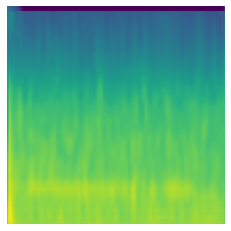

In [94]:
plt.imshow(out[0][0][0].detach().cpu().numpy());
plt.axis('off');

In [21]:
out[1].shape

torch.Size([8, 128])

In [23]:
class EegSpecFeats(Dataset):
    def __init__(self,
                 phase: str,
                 data_path: str = 'MDD'):
        files = os.listdir(f'{data_path}/{phase}')
        self.images = []
        self.filenames = []
        for f in files:
            self.images.append(torch.load(f'{data_path}/' + f'{phase}/' + f))
            self.filenames.append(f)
                         
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]
    def get_filenames(self):
        return self.filenames

In [29]:
health_dataset = EegSpecFeats(data_path = PATH_TO_SAVE_TENSORS, phase = 'Health')
mdd_dataset = EegSpecFeats(data_path = PATH_TO_SAVE_TENSORS, phase = 'MDD')
health_dataloader = DataLoader(health_dataset, batch_size = 10, shuffle = False, num_workers = 4)
mdd_dataloader = DataLoader(mdd_dataset, batch_size = 10, shuffle = False, num_workers = 4)

In [56]:
health_f = []
header = [f'f{i}' for i in range(128)]
isHeader = False
for data in health_dataloader:
    data = data.to(device)
    out = model(data)[1].detach().cpu().numpy()
    for row in out:
        if not isHeader:
            file = open(f'health.csv', 'w', newline = '')
            isHeader = True
            with file:
                writer = csv.writer(file)
                writer.writerow(header)        
        file = open(f'health.csv', 'a', newline = '')
        with file:
            writer = csv.writer(file)
            writer.writerow(row)

In [58]:
h = pd.read_csv('health.csv')
h.insert(0, 'file name', health_dataset.get_filenames())
h.to_csv('health.csv')

In [59]:
mdd_f = []
header = [f'f{i}' for i in range(128)]
isHeader = False
for data in mdd_dataloader:
    data = data.to(device)
    out = model(data)[1].detach().cpu().numpy()
    for row in out:
        if not isHeader:
            file = open(f'mdd.csv', 'w', newline = '')
            isHeader = True
            with file:
                writer = csv.writer(file)
                writer.writerow(header)        
        file = open(f'mdd.csv', 'a', newline = '')
        with file:
            writer = csv.writer(file)
            writer.writerow(row)

In [60]:
m = pd.read_csv('mdd.csv')
m.insert(0, 'file name', mdd_dataset.get_filenames())
m.to_csv('mdd.csv')

In [36]:
len(health_f[7])

5

In [45]:
health_f[7][0]

tensor([ 2.0948,  1.8812,  1.6527,  1.7678,  1.7166,  1.6069,  1.7088,  1.9060,
         0.6992,  0.6389,  0.5886,  0.6436,  0.5983,  0.6503,  0.7645,  0.8344,
         0.6952,  0.8466,  0.6301,  0.7302,  0.7343,  0.7623,  0.8546,  0.8041,
         0.8226,  0.7045,  0.6912,  0.6192,  0.6159,  0.6570,  0.7747,  0.7853,
         1.0181,  0.4639,  0.5384,  0.4713,  0.6332,  0.6866,  0.5807,  0.7493,
         1.0927,  0.7722,  0.7328,  0.5490,  0.5065,  0.5772,  0.5921,  0.9336,
         1.3305,  0.7891,  0.9573,  0.6127,  0.4914,  0.5120,  0.7163,  0.9842,
         2.5248,  1.4502,  1.9663,  1.0216,  0.9279,  1.1229,  1.5794,  1.7727,
        16.8642,  7.7779,  7.2417,  7.3572,  7.6402,  6.7321,  6.7653, 16.9557,
         6.7316,  4.3614,  3.8945,  4.9851,  4.7570,  4.5987,  6.8231,  6.7789,
         4.5484,  6.1570,  5.2453,  4.9310,  5.2493,  4.5872,  5.3296,  5.5320,
         4.6503,  7.0016,  5.4474,  4.3409,  3.9280,  4.5617,  5.3723,  4.2917,
         5.0872,  3.2753,  3.4196,  3.01

In [39]:
ret = health_f[7].detach().cpu().numpy()

In [46]:
header = [f'f{i}' for i in range(128)]

In [47]:
for row in ret:
    print(row)

[ 2.0948      1.8811898   1.6527247   1.7677598   1.7165964   1.6068639
  1.7088265   1.9060037   0.69916457  0.6388969   0.5886229   0.64362884
  0.5982817   0.65030634  0.7644639   0.8343842   0.69516736  0.846591
  0.630092    0.73021036  0.73432285  0.7622529   0.85460377  0.8040933
  0.822559    0.7045189   0.69122857  0.61923593  0.6158853   0.65703386
  0.77466357  0.7852755   1.0181283   0.46389386  0.5384315   0.47131556
  0.6331739   0.686637    0.58068556  0.7493251   1.092744    0.77223915
  0.73282534  0.54895383  0.50651217  0.57722557  0.59208286  0.9335909
  1.330488    0.78908676  0.95729005  0.6126683   0.49143702  0.5119864
  0.7162711   0.98417664  2.5248365   1.4501776   1.9663411   1.02163
  0.9278975   1.1228806   1.5793616   1.7726841  16.864157    7.777888
  7.2416787   7.357179    7.640246    6.732093    6.76525    16.955715
  6.7316017   4.3614354   3.8945317   4.985123    4.7569623   4.5987406
  6.823061    6.7789354   4.548403    6.156987    5.24531     4.9

In [35]:
# def create_megabatch(path_to_tensors):
#     health_batch = []
#     mdd_batch = []
#     for cls in os.listdir(path_to_tensors):
#         for tensor_name in os.listdir(path_to_tensors + f'{cls}/'):
#             filename = path_to_tensors + f'{cls}/' + tensor_name
#             tensor = torch.load(filename)
#             if cls == 'Health':
#                 health_batch.append(tensor)
#             else:
#                 mdd_batch.append(tensor)
#     return health_batch, mdd_batch

In [43]:
# health, mdd = create_megabatch(PATH_TO_SAVE_TENSORS)
# health_batch = torch.stack(health).to(device)
# mdd_batch = torch.stack(mdd).to(device)